# Image Understanding Final Project - Implementing GANS

In [1]:
import utils, torch, time, os, pickle
from matplotlib import pyplot as plt
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,models, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'# !pip install torchsummary 
from keras.datasets import fashion_mnist


Using TensorFlow backend.


# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
batch_size=100
z_dim = 64
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('Tshirt', 'Trouser', 'PullOver', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'BAg', 'Ankle Boot')


# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

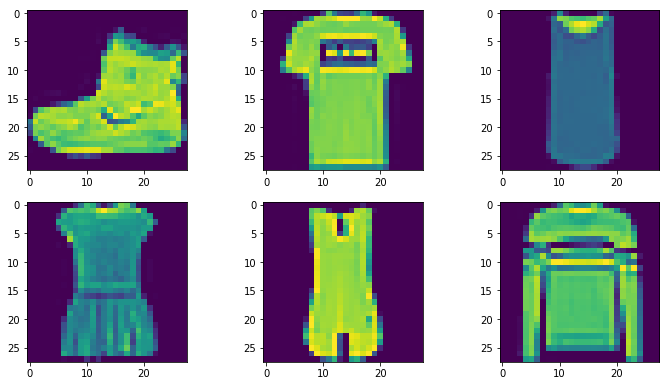

In [3]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. Later on I shifted to VGG networks which gave better accuracy. 
* After Implementing different VGG Networks, VGG13 gave the best results. 



In [4]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x
    
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
G_net = generator(input_dim=z_dim)
D_net = discriminator()
G_net.to(device)
D_net.to(device)
if device == 'cuda':
    G_net = torch.nn.DataParallel(G_net)
    D_net = torch.nn.DataParallel(D_net)
torch.backends.cudnn.benchmark = True

In [6]:
G_net
D_net

DataParallel(
  (module): discriminator(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
    )
    (fc): Sequential(
      (0): Linear(in_features=8192, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=1024, out_features=1, bias=True)
      (4): Sigmoid()
    )
  )
)

In [7]:
G_optimizer = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay= 5e-4)
D_optimizer = optim.Adam(D_net.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay= 5e-4)
criterion =  nn.BCELoss()


In [8]:
y_real_, y_fake_ = torch.ones(batch_size, 1), torch.zeros(batch_size, 1)
if device == 'cuda':
    y_real_,y_fake_ = y_real_.to(device), y_fake_.to(device)
# fixed noise
sample_z_ = torch.rand((batch_size, z_dim))

In [9]:
# sample_z_.shape

In [10]:
train_hist = {}
train_hist['D_loss'] = []
train_hist['G_loss'] = []
train_hist['D_loss_epoch'] = []
train_hist['G_loss_epoch'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []
epochs = 10
img = []

## Training

In [11]:
def train():
    D_net.train()
    print('training start!!')
    start_time = time.time()
    for epoch in range(epochs):
        G_net.train()
        epoch_start_time = time.time()
#     print(criterion)
#     training_loss = 0
#     train_correct = 0
#     lo = []
        for batch_idx, (data, target) in enumerate(train_loader):
        
            #==== Updating Discriminative Network=====#

            #==== Making Random Noise=====#
            z_ = torch.rand((batch_size, z_dim))
            data, target, z_ = data.to(device), target.to(device), z_.to(device)

            D_optimizer.zero_grad()

            #==== Forward Pass for Discriminator=====
            D_real = D_net(data)
            D_real_loss = criterion(D_real, y_real_)

            #==== Forward Pass for Generative=====
            G_ = G_net(z_)
            D_fake = D_net(G_)
            D_fake_loss = criterion(D_fake, y_fake_)

            #==== Total Loss=====
            D_loss = D_real_loss + D_fake_loss
            train_hist['D_loss'].append(D_loss.item())

            #=====Backward Pass=======
            D_loss.backward()
            D_optimizer.step()

            #==== Updating Generative Network=====#

            G_optimizer.zero_grad()        
             #==== Forward Pass for Generative=====
            G_ = G_net(z_)
            D_fake = D_net(G_)

            #==== Total Loss=====
            G_loss = criterion(D_fake, y_real_)
            train_hist['G_loss'].append(G_loss.item())
            #=====Backward Pass=======
            G_loss.backward()
            G_optimizer.step()

            if ((batch_idx + 1) % 100) == 0:
                print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
    ((epoch + 1), (batch_idx + 1), train_loader.dataset.__len__() // batch_size, D_loss.item(), G_loss.item()))

        train_hist['per_epoch_time'].append(time.time() - epoch_start_time)            
        train_hist['G_loss_epoch'].append(np.mean(train_hist['G_loss']))
        train_hist['D_loss_epoch'].append(np.mean(train_hist['D_loss']))
        with torch.no_grad():
            visualize_results()

    train_hist['total_time'].append(time.time() - start_time)
    print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']),
              epoch, train_hist['total_time'][0]))
    print("Training finish!... save training results")
    save()

def save():
    save_dir = "./models/"
    torch.save(G_net, os.path.join(save_dir,  '_G1.pkl'))
    torch.save(D_net, os.path.join(save_dir,'_D1.pkl'))
    torch.save(G.state_dict(), os.path.join(save_dir, self.model_name + '_G_state.pkl'))
    torch.save(D.state_dict(), os.path.join(save_dir, self.model_name + '_D_state.pkl'))
    np.save('./models/train_hist.npy', train_hist)
    np.save('./models/img.npy', img)
    
    
    with open(os.path.join(save_dir, '_history1.pkl'), 'wb') as f:
        pickle.dump(train_hist, f)
        
    with open(os.path.join(save_dir, '_img1.pkl'), 'wb') as g:
        pickle.dump(img, g)
        
def load():
    save_dir = "./models/"
#     G_net =generator(input_dim=z_dim)
#     D_net = discriminator()
    G_net= torch.load(os.path.join(save_dir, '_G1.pkl'))
    D_net =torch.load(os.path.join(save_dir, '_D1.pkl'))
#     train_hist = np.load('./models/train_hist.npy')
#     img = np.load('./models/img.npy')
    with open(os.path.join(save_dir, '_history1.pkl'), 'rb') as f:
        train_hist = pickle.load(f)
    with open(os.path.join(save_dir, '_img1.pkl'), 'rb') as g:
        img = pickle.load(g)
        
def visualize_results(fix=True):
    G_net.eval()
#     sample_z_ = torch.rand((batch_size, z_dim))
    result_dir = "./results/"
#     print(sample_z_.shape)
    if fix:
        """ fixed noise """
        samples = G_net(sample_z_)
    else:
        """ random noise """
        sample_z = torch.rand((batch_size,z_dim))
        sample_z = sample_z.cuda()
        samples = G_net(sample_z)
    samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    img.append(samples)
        

In [12]:
train()

training start!!
Epoch: [ 1] [ 100/ 600] D_loss: 1.12944388, G_loss: 0.90945262
Epoch: [ 1] [ 200/ 600] D_loss: 1.04977059, G_loss: 0.94979596
Epoch: [ 1] [ 300/ 600] D_loss: 0.98271930, G_loss: 1.10446966
Epoch: [ 1] [ 400/ 600] D_loss: 0.99767840, G_loss: 1.07415080
Epoch: [ 1] [ 500/ 600] D_loss: 1.01693571, G_loss: 0.99413955
Epoch: [ 1] [ 600/ 600] D_loss: 1.10271668, G_loss: 1.18216550
Epoch: [ 2] [ 100/ 600] D_loss: 1.01823926, G_loss: 1.16504622
Epoch: [ 2] [ 200/ 600] D_loss: 0.93155193, G_loss: 1.13919842
Epoch: [ 2] [ 300/ 600] D_loss: 1.15102136, G_loss: 1.16965687
Epoch: [ 2] [ 400/ 600] D_loss: 0.95959020, G_loss: 1.14960563
Epoch: [ 2] [ 500/ 600] D_loss: 0.99711812, G_loss: 1.12373018
Epoch: [ 2] [ 600/ 600] D_loss: 1.00239122, G_loss: 1.10324097
Epoch: [ 3] [ 100/ 600] D_loss: 1.16168761, G_loss: 1.02161551
Epoch: [ 3] [ 200/ 600] D_loss: 1.01169109, G_loss: 1.16596210
Epoch: [ 3] [ 300/ 600] D_loss: 1.06852186, G_loss: 1.13523030
Epoch: [ 3] [ 400/ 600] D_loss: 1.0030

/home/anirudh/detect/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/anirudh/detect/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Visualizing Losses

Discriminative Loss: 0.8781222105026245
Generative Loss: 1.3873339891433716
Time to run 10 epochs = [455.24204206466675]s


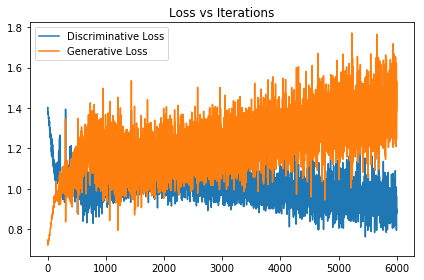

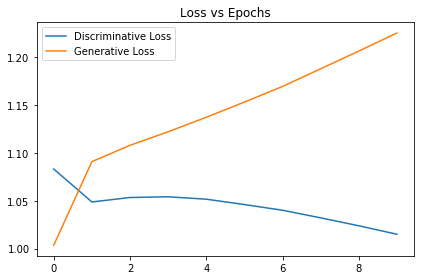

In [15]:
# Plot Graphs
# load()
dloss= train_hist['D_loss'] 
gloss= train_hist['G_loss']
dlossEpoch= train_hist['D_loss_epoch'] 
glossEpoch= train_hist['G_loss_epoch']

tottime = train_hist['total_time'] 

print('Discriminative Loss:', dloss[-1])
print('Generative Loss:', gloss[-1])
print('Time to run ' + str(epochs)+  ' epochs = ' + str(tottime)+'s')

plt.plot(dloss,label='Discriminative Loss')
plt.plot(gloss, label='Generative Loss')
plt.title('Loss vs Iterations')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(dlossEpoch,label='Discriminative Loss')
plt.plot(glossEpoch, label='Generative Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.tight_layout()
plt.show()

## Visualizing Outputs from Trained Generative Model

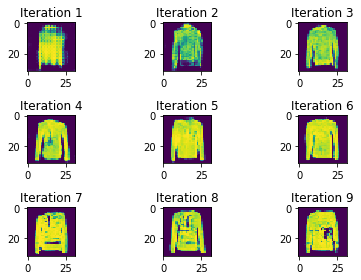

In [24]:
# img[0].shape
k=0
for i in range(9): 
    plt.subplot(3,3, i+1)
    plt.imshow(img[k][3][:,:,0],interpolation='nearest')
    plt.title("Iteration "+ str(k+1) )
    k=k+1
plt.tight_layout()
plt.show()